# Vocie Tracker Activity

Implementare un pitch tracker basato su STACF, usando una analisi con finestre da 30ms, con shift di 10ms. Usando le vocali sintetizzate disponibili. Usando il tracker su speech sintetico e voiced, con F0 conosciuta e Fs=8Khz disponibile, definite come -pout.wav.

## Funzione di Autocorrelazione

In [1]:
# per prima cosa dobbiamo caricare il segnale della vocale AA
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy 
import scipy.io
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np

/home/gabriele/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
fs = 8e3 # 8kHz
T_w = 30e-3 # 30ms
T_s = 10e-3 # 10 ms

Tramite l'autocorrelazione dovremmo riuscire a beccarei il pitch, usando la finestra da 30ms

Sample rate:  8000.0
Data:  (3992,)
numero di campioni = 3992
length (durata)= 0.499 s


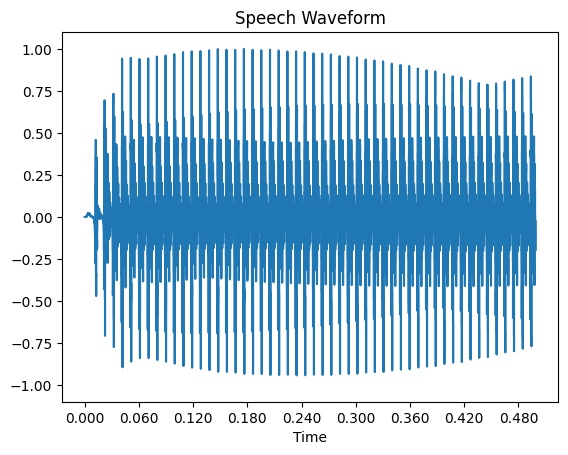

In [7]:
import librosa
import matplotlib.pyplot as plt

filename = "audio/aa-pout-105Hz-8kHz.wav"
data, sample_rate = librosa.load(filename, sr=fs)

print("Sample rate: ", sample_rate)
print("Data: ", data.shape)
print(f"numero di campioni = {data.shape[0]}")
# print(f"frequenza di campionamento: {samplerate}")
length = data.shape[0] / sample_rate
print(f"length (durata)= {length} s")

# Plot the waveform
plt.figure()
librosa.display.waveshow(data, sr=sample_rate)
plt.title("Speech Waveform")
plt.show()

Step successivo è quello di andare a finestrare il segnale, andando ad estrarre una finestra

In [8]:
def finestramento(data, t_win, t_step, fs):
    # ogni finestra deve avere un numero di campioni pari a t_win * fs
    n_win = int(t_win * fs)
    # dopodiché devo iniziare ad estrarre a partire dal primo campione, spostandomi ogni volta di
    n_step = int(t_step * fs)
    print(f"Numero campioni per finestra: {n_win}")
    print(f"Numero campioni di step: {n_step}")
    n_frames = int((data.shape[0] - n_win) / n_step)
    windows = []
    for i in range(n_frames):
        start_index = i * n_step
        end_index = start_index + n_win
        win = data[start_index:end_index]
        windows.append(win)
    return windows

segmenti = finestramento(data, T_w, T_s, fs)
len(segmenti)


Numero campioni per finestra: 240
Numero campioni di step: 80


46

In [9]:
segmento_1 = segmenti[0]
print(segmento_1.shape)
auto_correlazione = np.correlate(segmento_1, segmento_1, "full") # calcola la auto correlazione per ogni k lag
print(auto_correlazione.shape)

(240,)
(479,)


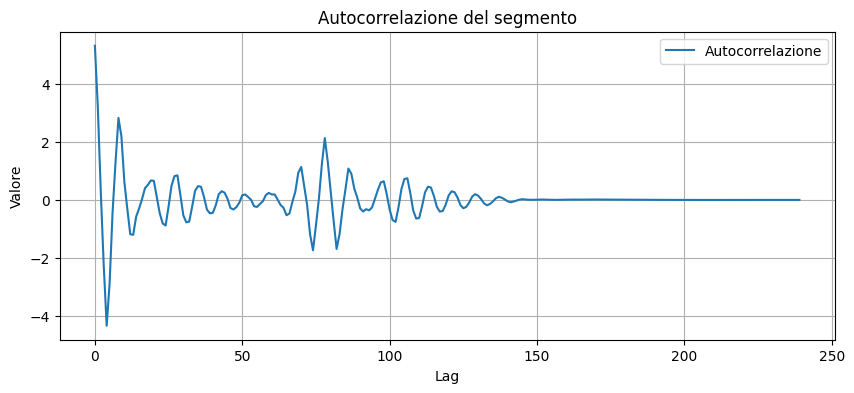

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Asse temporale, lo stampo come lag
lag = np.arange(0, len(segmento_1))

# Plot
plt.figure(figsize=(10, 4))
plt.plot(lag, auto_correlazione[239:], label="Autocorrelazione") 
# prendo solo la parte positiva dell'autocorrelazione dato che è simmetrica
plt.xlabel("Lag")
plt.ylabel("Valore")
plt.title("Autocorrelazione del segmento")
plt.legend()
plt.grid()
plt.show()

Nel caso in cui il segnale presenta una frequenza fondamentale di 410Hz, la dimensione della finestra è troppo grande per riuscire a "prendere" il pitch. Quindi la soluzione dovrebbe essere quella di finestrare il segnale, applicare quindi il central clipping e continuare con l'analisi. Con il central clipping riusciamo quindi a eliminare eventuali "picchi". 

# STACF

Adesso quello che dobbiamo fare è, per ogni frame del segnale, andare ad estrarre il valore di peak del pitch

Numero campioni per finestra: 240
Numero campioni di step: 80
(240,)
(479,)


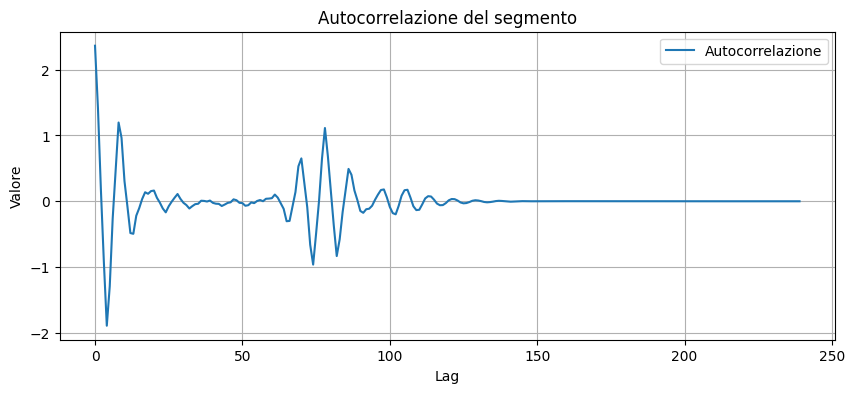

In [27]:
def finestramento(data, t_win, t_step, fs):
    # ogni finestra deve avere un numero di campioni pari a t_win * fs
    n_win = int(t_win * fs)
    # dopodiché devo iniziare ad estrarre a partire dal primo campione, spostandomi ogni volta di
    n_step = int(t_step * fs)
    print(f"Numero campioni per finestra: {n_win}")
    print(f"Numero campioni di step: {n_step}")
    n_frames = int((data.shape[0] - n_win) / n_step)
    windows = []
    for i in range(n_frames):
        start_index = i * n_step
        end_index = start_index + n_win
        win = data[start_index:end_index] * np.hamming(n_win) # uso la finestra di hamming
        windows.append(win)
    return windows


segmenti = finestramento(data, T_w, T_s, fs)
len(segmenti)
segmento_1 = segmenti[0]
print(segmento_1.shape)
auto_correlazione = np.correlate(segmento_1, segmento_1, "full") # calcola la auto correlazione per ogni k lag
print(auto_correlazione.shape)

positive_auto  = auto_correlazione[len(auto_correlazione)//2:]

# Asse temporale, lo stampo come lag
lag = np.arange(0, len(segmento_1))

# Plot
plt.figure(figsize=(10, 4))
plt.plot(lag, positive_auto, label="Autocorrelazione") 
# prendo solo la parte positiva dell'autocorrelazione dato che è simmetrica
plt.xlabel("Lag")
plt.ylabel("Valore")
plt.title("Autocorrelazione del segmento")
plt.legend()
plt.grid()
plt.show()

Per capire dove andare a cercare il il peak nella funzione di autocorrelazione devo andare a cercare il picco in un intervallo specifico, definito come L_window/fs

In [17]:
# Limiti basati sulle frequenze desiderate
max_freq = 450
min_freq = 70
min_lag = int(fs / max_freq)
max_lag = int(fs / min_freq)
print(f"Intervallo: {min_lag}-{max_lag}")

Intervallo: 17-114


In [28]:
# Trova il massimo nella regione valida
peak_index = np.argmax(positive_auto[min_lag:max_lag]) + min_lag
pitch_freq = fs / peak_index  # Converti lag in frequenza
print(f"Pitch freq: {pitch_freq}")

Pitch freq: 102.56410256410257


Adesso che sappiamo quanto vale il pitch stimato per il primo segmento, automatizziamo il processo, andando quindi a plottare:
- il segnale nel dominio del tempo
- i pitch corrispettivi per ogni finestra temporale
- il pitch track per ogni finestra

In [46]:
def finestramento(data, t_win=T_w, t_step=T_s, fs=fs):
    '''
    Finestra un segnale nel dominio del tempo per estrarre un segmento
    '''
    # ogni finestra deve avere un numero di campioni pari a t_win * fs
    n_win = int(t_win * fs) # circa 240 frame size
    # dopodiché devo iniziare ad estrarre a partire dal primo campione, spostandomi ogni volta di
    n_step = int(t_step * fs) # circa 80 come frame step
    print(f"Numero campioni per finestra: {n_win}")
    print(f"Numero campioni di step: {n_step}")
    n_frames = int((data.shape[0] - n_win) / n_step)
    windows = []
    for i in range(n_frames):
        start_index = i * n_step
        end_index = start_index + n_win
        win = data[start_index:end_index] * np.hamming(n_win) 
        # uso la finestra di hamming per ridurre rumore, come se fosse passabbasso
        windows.append(win)
    return windows


def find_peak_segment(segmento, fs=fs):
    '''
    Questa funzione permette di trovare il pitch peak per ogni segmento,
    andando a calcolare la funzione di autocorrelazione per un dato segmento.
    I valori di massimo e minimo dove andare a cercare il pitch ci vengono forniti dai valori medi:
    max_f0 = 450
    min_f0 = 70
    '''
    # Limiti basati sulle frequenze desiderate
    max_freq = 500
    min_freq = 100
    min_lag = int(fs / max_freq)
    max_lag = int(fs / min_freq)
    # print(segmento)
    segmento = segmento - np.mean(segmento) # rimuovo la DC component
    auto_correlazione = np.correlate(segmento, segmento, "full") # calcola la auto correlazione per ogni k lag
    simm_auto_correlazione = auto_correlazione[len(auto_correlazione)//2:] # prendo la parte positiva
    peak_index = np.argmax(simm_auto_correlazione[min_lag:max_lag]) + min_lag
    pitch_freq = fs / peak_index  # Converti lag in frequenza
    # print(f"Pitch freq: {pitch_freq}")
    return pitch_freq


In [35]:
def stacf(data, T_win=T_w, T_step=T_s):
    '''
    Dato un segnale data:
    - calcolo i segmenti
    - per ogni segmento calcolo la funzione di autocorrelazione
    '''
    frame_length = T_win
    frame_hop_length = T_step
    frames = finestramento(data, t_win=frame_length, t_step=frame_hop_length)
    pitch_peaks = []
    for frame in frames:
        peaks = find_peak_segment(frame)
        pitch_peaks.append(peaks)
    return pitch_peaks

In [37]:
peaks = stacf(data)
len(peaks)

Numero campioni per finestra: 240
Numero campioni di step: 80


46

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def plot_signal_and_peaks(data, pitch_peaks, T_win, T_step, sr):
    '''
    Plotta il segnale originale e i picchi della funzione di autocorrelazione per ogni frame.
    
    - data: segnale originale
    - pitch_peaks: lista dei picchi della funzione di autocorrelazione per ogni frame
    - T_win: durata della finestra in campioni
    - T_step: step tra le finestre in campioni
    - sr: frequenza di campionamento
    '''
    
    # Creiamo l'asse temporale del segnale originale
    time_signal = np.arange(len(data)) / sr
    
    # Creiamo l'asse temporale dei frame centrati
    num_frames = len(pitch_peaks)
    frame_times = np.arange(num_frames) * (T_step / sr)  # Tempo in secondi

    # Creiamo i dati per il plot scatter dei picchi
    peak_frequencies = [sr / peak if peak > 0 else 0 for peak in pitch_peaks]
    
    # Figura
    plt.figure(figsize=(10, 5))
    
    # Plotta il segnale originale
    plt.subplot(2, 1, 1)
    plt.plot(time_signal, data, label="Segnale originale", color="blue")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Ampiezza")
    plt.legend()
    
    # Plotta i picchi come scatter plot
    plt.subplot(2, 1, 2)
    plt.plot(frame_times, peak_frequencies, color='red', marker='o', label="Pitch Peaks")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Frequenza (Hz)")
    plt.title("Pitch Stimato per ogni Frame")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

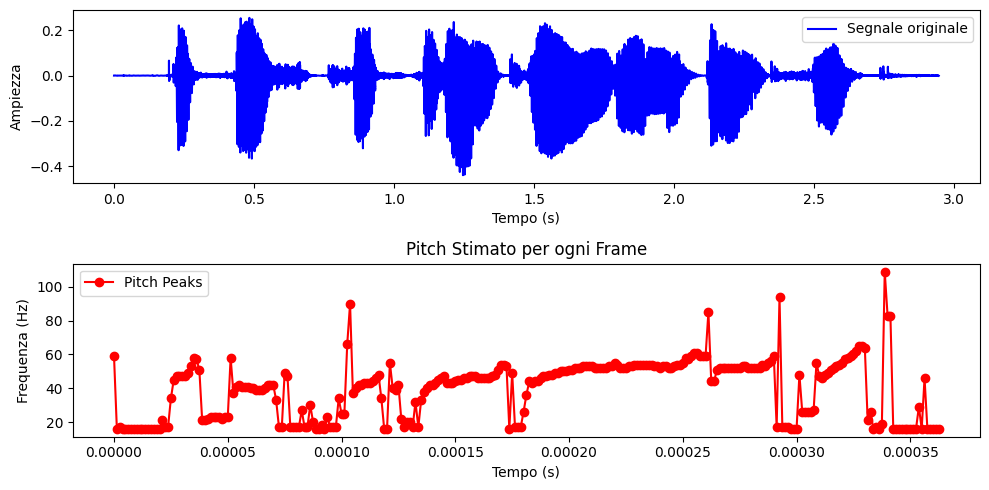

In [47]:
plot_signal_and_peaks(data, peaks, T_w, T_s, fs)

# Simulazione su più forme d'onda

In [44]:
import os
import librosa

folder_path = "audio/"  # Cartella contenente i file audio
# Trova tutti i file audio nella cartella
audio_files = [f for f in os.listdir(folder_path) if f.endswith((".wav", ".mp3", ".flac"))]
len(audio_files)

15

File: speech3_10k.wav
Sample rate: 8000.0
Numero di campioni: 19205
Durata: 2.40 s
Numero campioni per finestra: 240
Numero campioni di step: 80


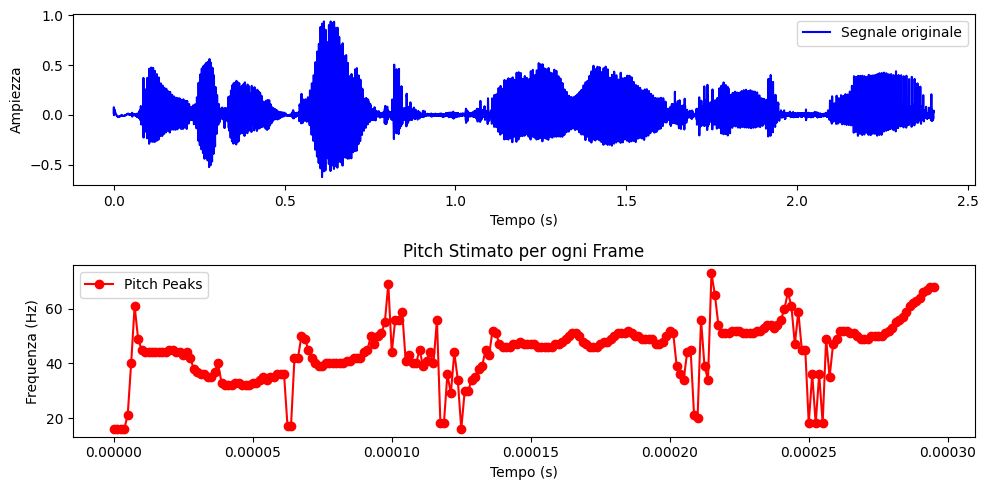

----------------------------------------
File: ih-pout-410Hz-8kHz.wav
Sample rate: 8000.0
Numero di campioni: 3992
Durata: 0.50 s
Numero campioni per finestra: 240
Numero campioni di step: 80


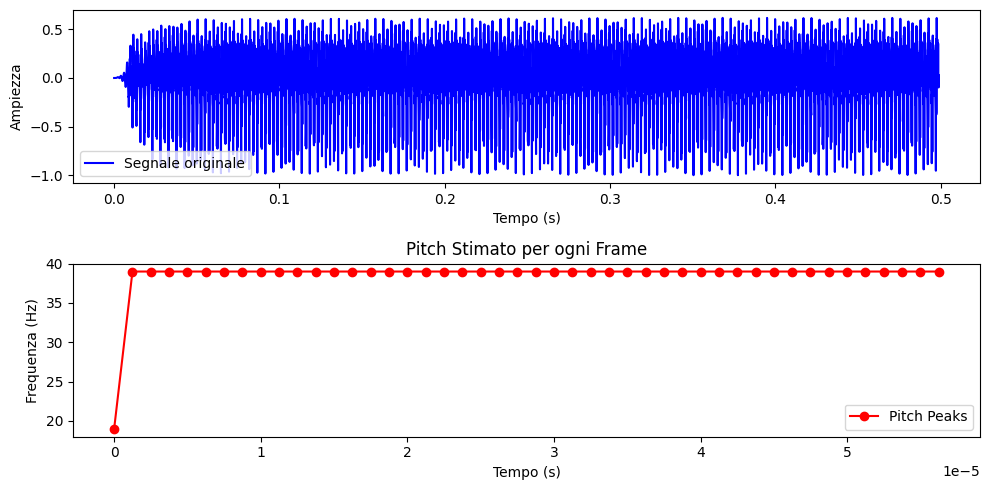

----------------------------------------
File: ae-pout-230Hz-8kHz.wav
Sample rate: 8000.0
Numero di campioni: 3992
Durata: 0.50 s
Numero campioni per finestra: 240
Numero campioni di step: 80


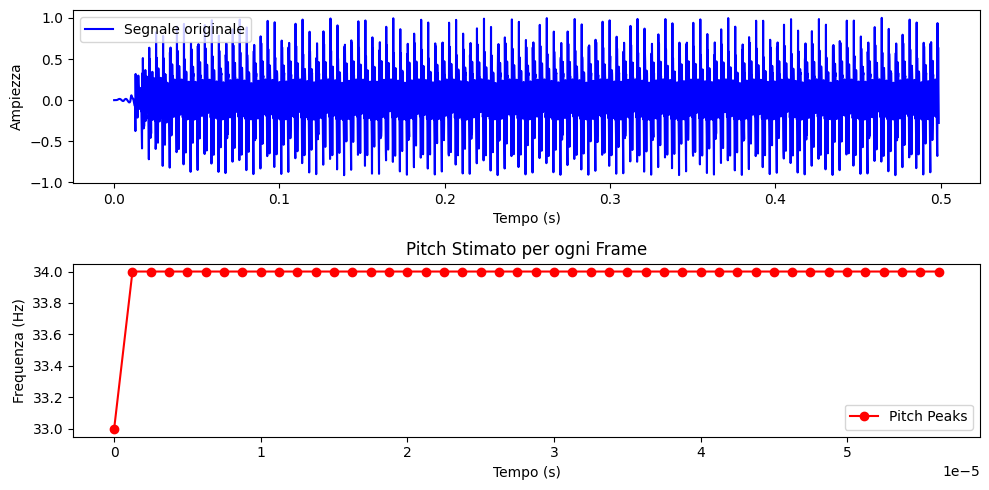

----------------------------------------
File: ae-pout-255Hz-8kHz.wav
Sample rate: 8000.0
Numero di campioni: 3992
Durata: 0.50 s
Numero campioni per finestra: 240
Numero campioni di step: 80


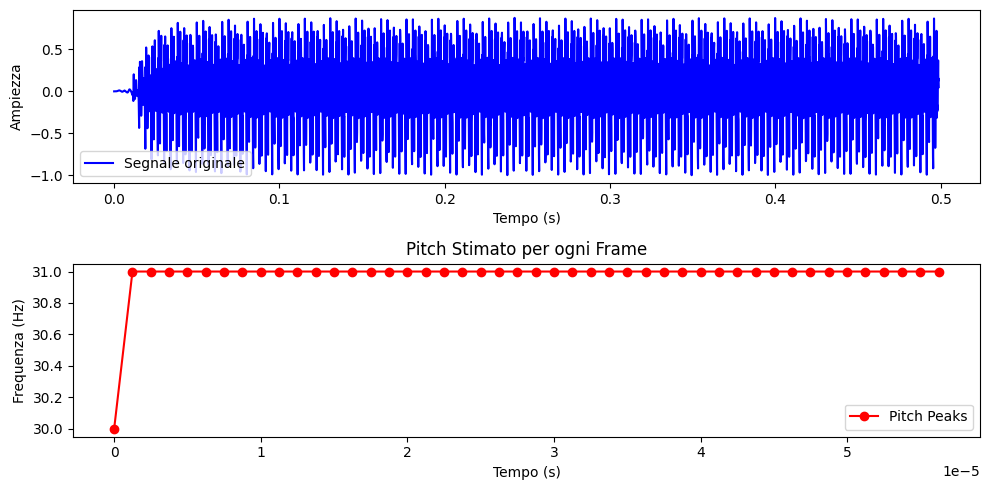

----------------------------------------
File: eh-pout-410Hz-8kHz.wav
Sample rate: 8000.0
Numero di campioni: 3992
Durata: 0.50 s
Numero campioni per finestra: 240
Numero campioni di step: 80


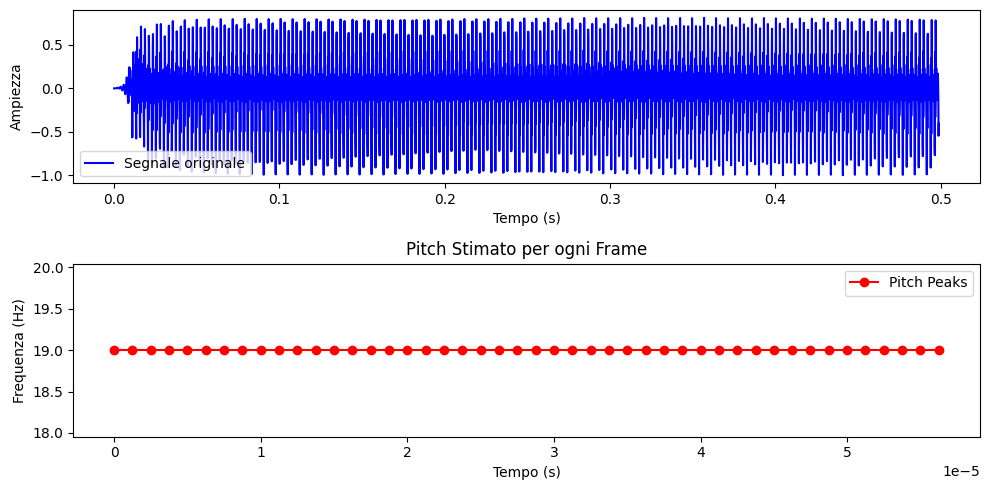

----------------------------------------
File: aa-pout-115Hz-8kHz.wav
Sample rate: 8000.0
Numero di campioni: 3992
Durata: 0.50 s
Numero campioni per finestra: 240
Numero campioni di step: 80


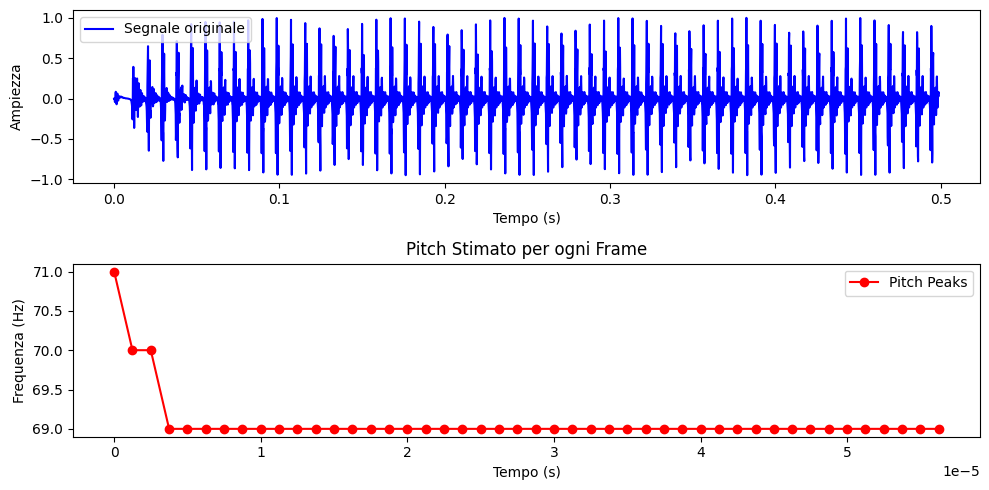

----------------------------------------
File: aa-pout-105Hz-8kHz.wav
Sample rate: 8000.0
Numero di campioni: 3992
Durata: 0.50 s
Numero campioni per finestra: 240
Numero campioni di step: 80


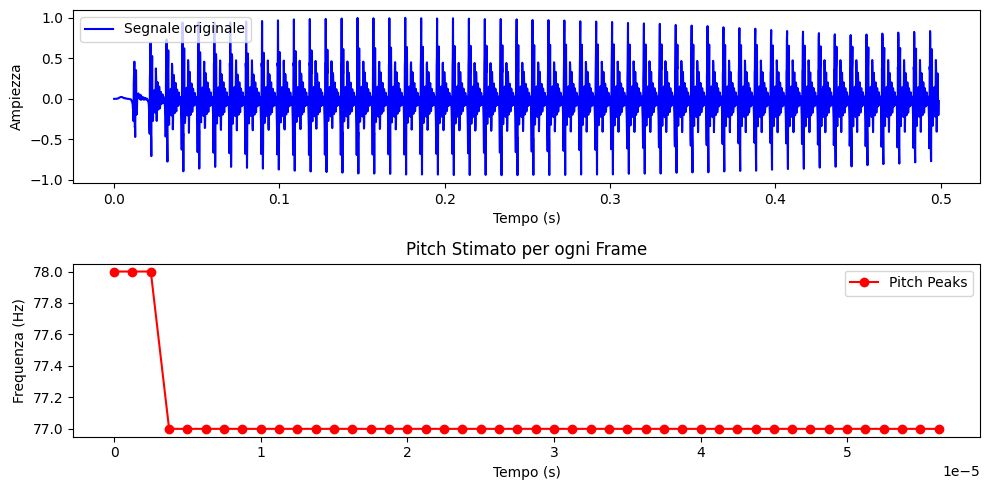

----------------------------------------
File: arctic_a0049-sin.wav
Sample rate: 8000.0
Numero di campioni: 32000
Durata: 4.00 s
Numero campioni per finestra: 240
Numero campioni di step: 80


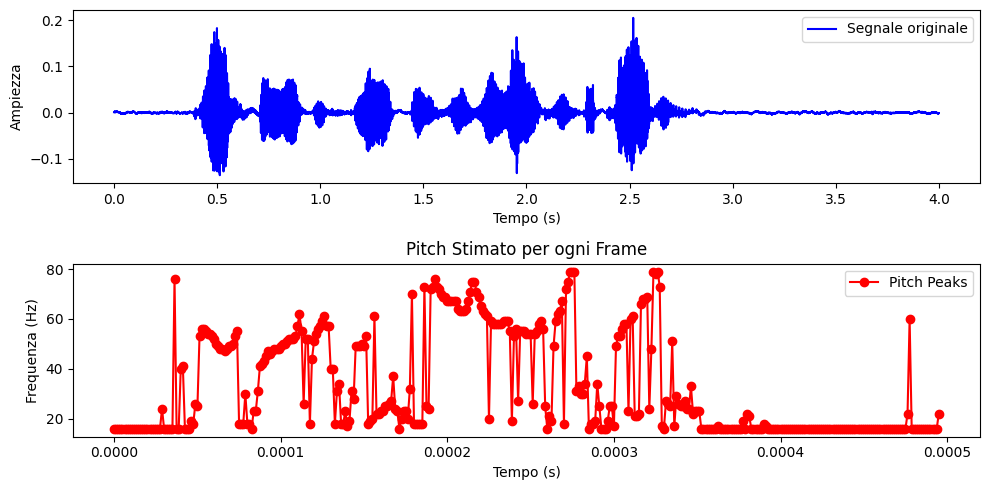

----------------------------------------
File: aa-pout-205Hz-8kHz.wav
Sample rate: 8000.0
Numero di campioni: 3992
Durata: 0.50 s
Numero campioni per finestra: 240
Numero campioni di step: 80


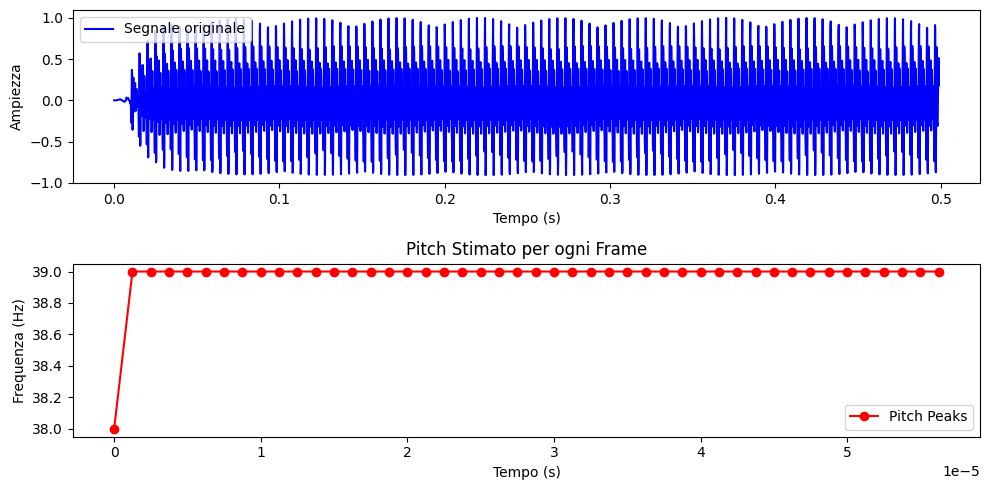

----------------------------------------
File: eh-pout-310Hz-8kHz.wav
Sample rate: 8000.0
Numero di campioni: 3992
Durata: 0.50 s
Numero campioni per finestra: 240
Numero campioni di step: 80


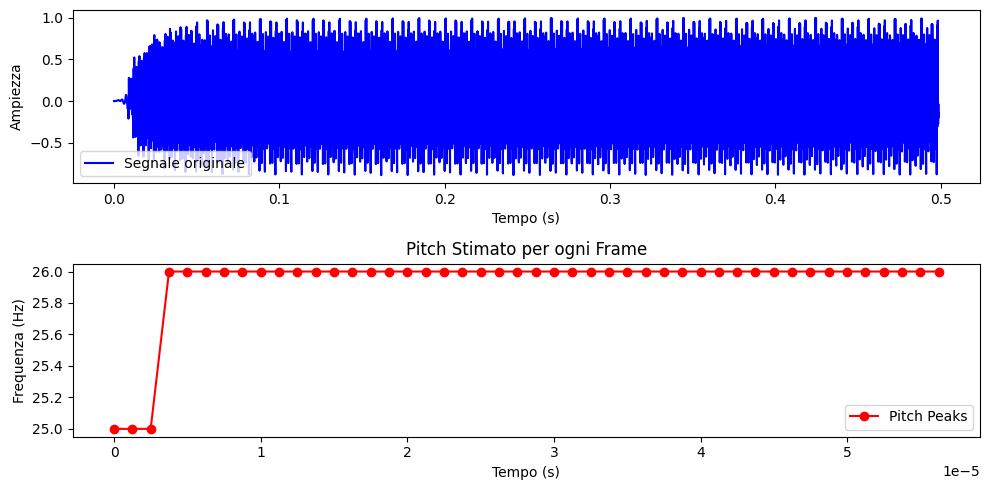

----------------------------------------
File: ae-pout-315Hz-8kHz.wav
Sample rate: 8000.0
Numero di campioni: 3992
Durata: 0.50 s
Numero campioni per finestra: 240
Numero campioni di step: 80


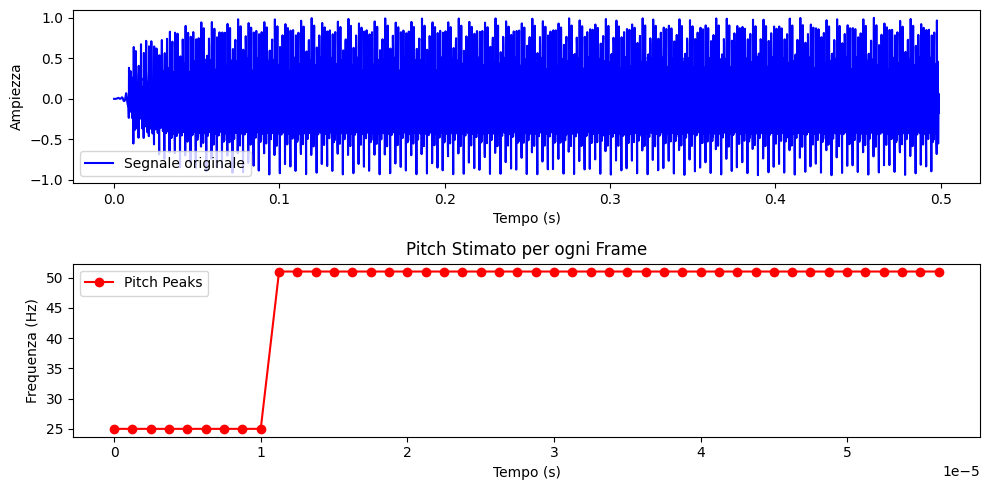

----------------------------------------
File: arctic_a0049-swn.wav
Sample rate: 8000.0
Numero di campioni: 32000
Durata: 4.00 s
Numero campioni per finestra: 240
Numero campioni di step: 80


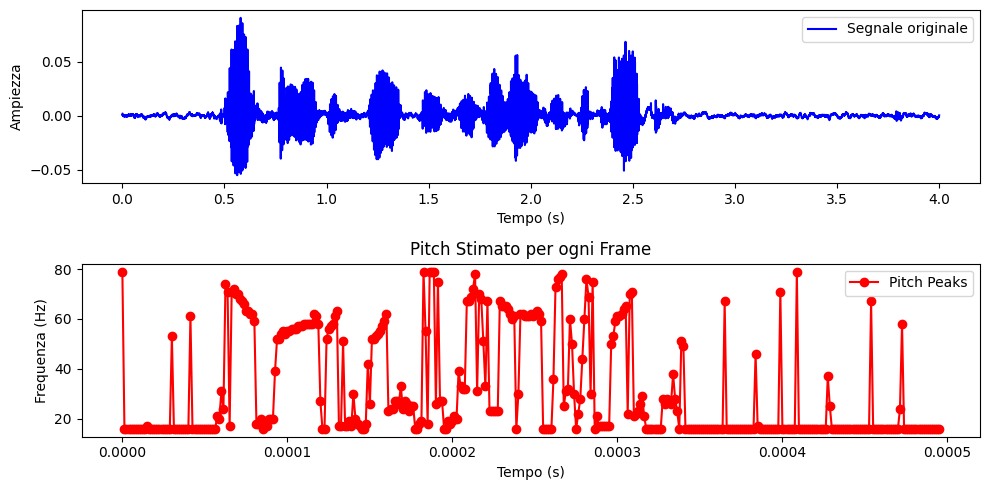

----------------------------------------
File: ih-pout-310Hz-8kHz.wav
Sample rate: 8000.0
Numero di campioni: 3992
Durata: 0.50 s
Numero campioni per finestra: 240
Numero campioni di step: 80


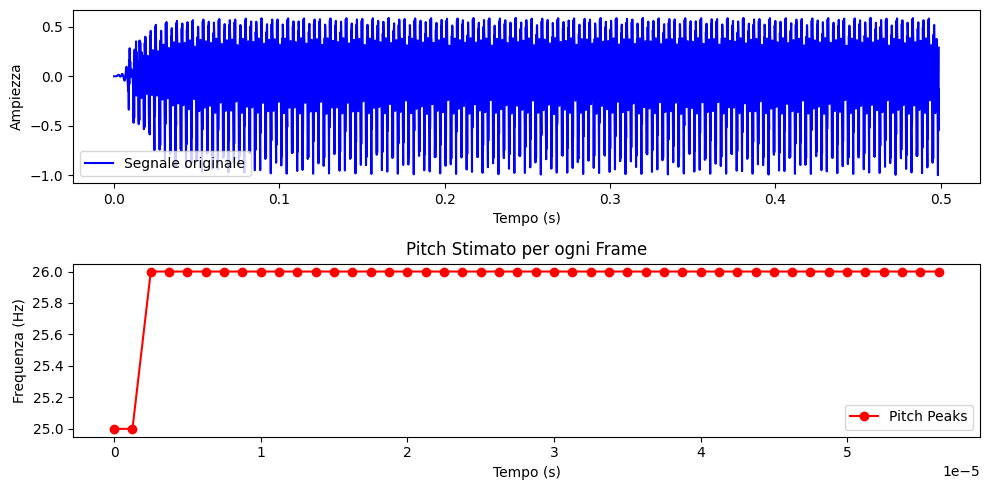

----------------------------------------
File: speech2_10k.wav
Sample rate: 8000.0
Numero di campioni: 16005
Durata: 2.00 s
Numero campioni per finestra: 240
Numero campioni di step: 80


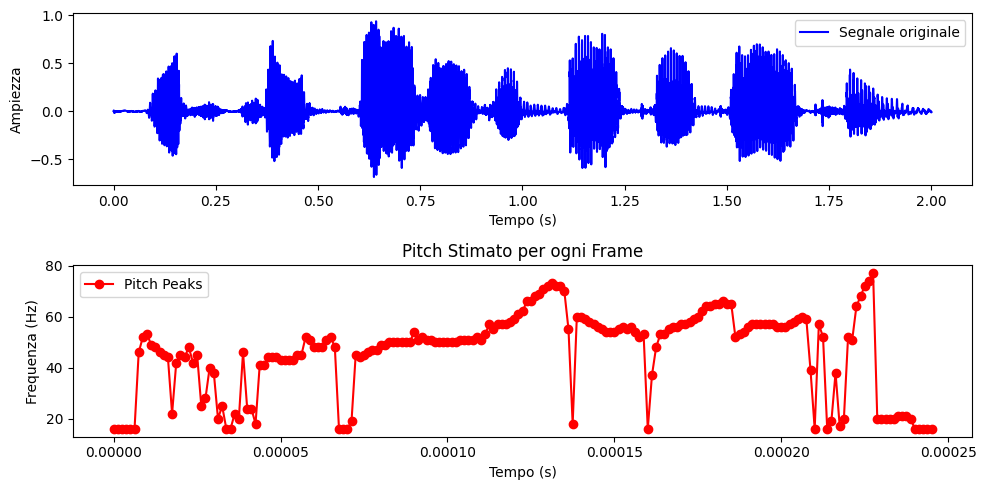

----------------------------------------
File: H.22.16k.wav
Sample rate: 8000.0
Numero di campioni: 23563
Durata: 2.95 s
Numero campioni per finestra: 240
Numero campioni di step: 80


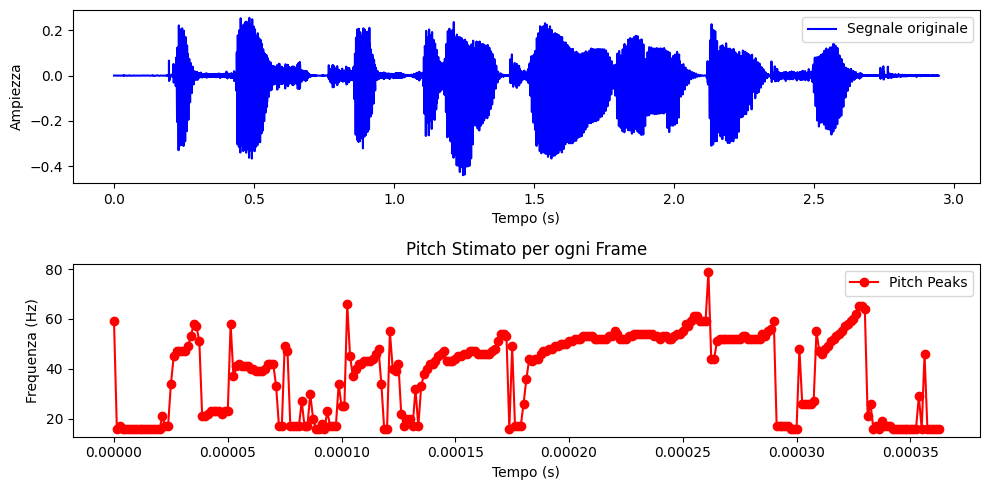

----------------------------------------


In [48]:
for audio_file in audio_files:
    filepath = os.path.join(folder_path, audio_file)
    data, sample_rate = librosa.load(filepath, sr=fs)
    print(f"File: {audio_file}")
    print(f"Sample rate: {sample_rate}")
    print(f"Numero di campioni: {data.shape[0]}")
    print(f"Durata: {data.shape[0] / sample_rate:.2f} s")
    peaks = stacf(data)
    plot_signal_and_peaks(data, peaks, T_w, T_s, fs)
    print("-" * 40)